In [1]:
!pip install python-Levenshtein
!pip install clearml
!pip install python-dotenv
!pip install pymorphy2
!pip install corus razdel
!pip install datasets
!pip install seqeval
!pip install evaluate
!pip install tokenizers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 91.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=97015275b9b20cba241786f49fa205d693ff6a7d1f222373f01e9b225fc9bcc9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00


### Решение задачи детекции мата с помощью cловаря

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from wordcloud import WordCloud
from collections import Counter
from typing import List
import string
import os
import json

from dotenv import load_dotenv
from clearml import Task, OutputModel
import pickle

import Levenshtein
from nltk.stem import PorterStemmer, SnowballStemmer
import pymorphy2

from typing import Callable


load_dotenv('/kaggle/input/dotenvs/.env.proj')

API_ACCESS_KEY=os.environ.get('API_ACCESS_KEY')
API_SECRET_KEY=os.environ.get('API_SECRET_KEY')

data = pd.read_csv("/kaggle/input/wildberries-winter-school-24-contest-detected/train.csv")
test = pd.read_csv('/kaggle/input/wildberries-winter-school-24-contest-detected/test.csv')
data

,ID,text,label
0,0,"брюки отличные, качественные, но к сожалению коротко ваты, поэтому отказ, обидно, продавца рекомендую всем",NaN
1,1,"отличный аппарат, в комплекте кабель и работетт от сети , а значит можно сразу приступать к измерению давления.",NaN
2,2,супер 👍 спасибо большое,NaN
3,3,получил быстро данные наушники! к наушникам пришёл прикольный чехол. проблем с подключением не было 😇,NaN
4,4,всё дошло в целости и сохранности),NaN
...,...,...,...
244734,248088,мне ее порвали суки,суки
244735,248089,"Полное дерьмо, удалите этот товар и заблокируйте продавца",дерьмо
244736,248090,Херня. Деньги на ветер.,херня
244737,248091,"Это вообще что , за 💩 гов... ще?? Темнотища ужас!! Тонкая промашка 👎, рвётся, морщица и не расправляется, рисунок в некоторых местах не совпадает.. Еле от стены отшкрябала, в полном смысле. Стена новый гипсокартон, весь в краске покрасился🤦не рекомендую 👎👎👎👎 от слова СОВСЕМ!!!!",гов... ще


In [3]:
# фиксируем сид, для воиспрозводимости экспериментов

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
#Настройка переменных окружения для подключение к clearml

os.environ['CLEARML_WEB_HOST'] = 'https://app.clear.ml/'
os.environ['CLEARML_API_HOST'] = 'https://api.clear.ml'
os.environ['CLEARML_FILES_HOST'] = 'https://files.clear.ml'
os.environ['CLEARML_API_ACCESS_KEY'] = f'{API_ACCESS_KEY}'
os.environ['CLEARML_API_SECRET_KEY'] = f'{API_SECRET_KEY}'

In [5]:
# загрузка объектов для процесинга слов (стеминг, лиматизация)

morph = pymorphy2.MorphAnalyzer()
ss = SnowballStemmer(language='russian')

In [6]:
# формирование словаря мата из исходного датасета

data_train, data_test = train_test_split(data, test_size=0.2)


data_mat = data_train[~data_train['label'].isna()].copy()
vocab = set()
vocab_list = []
for text in tqdm(data_mat['label'], unit_scale=True):
    for word in text.lower().split(','):
        vocab.add(word.strip().lower())
        vocab_list.append(word.strip().lower())
        
print(f'Размер словаря: {len(vocab)}')


# data_mat = data_train[~data_train['label'].isna()].copy()
# vocab = set()
# for text in tqdm(data_mat['label'], unit_scale=True):
#     for word in text.split(','):
#         vocab.add(word.strip().lower())
        
# print(f'Размер словаря до стеминга: {len(vocab)}')
# vocab = set(list(map(ss.stem, vocab)))
# print(f'Размер словаря после стеминга: {len(vocab)}')

100%|██████████| 27.9k/27.9k [00:00<00:00, 686kit/s]

Размер словаря: 3180


In [7]:
def analysis(data: pd.DataFrame, vocab: set, processing=None) -> pd.DataFrame:
    """
    Данная фнукция подсчитывает сколько раз каждое слово в словаре является и/или
    не является матом в исходном датафрейме
    """
    analys = {word: [0, 0] for word in vocab}
    
    for i, row in tqdm(data.iterrows(), unit_scale=True):
        prccessed_text = row['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        words_in_text = prccessed_text.strip().split()

        if processing == 'staming':
            words_in_text = list(map(ss.stem, words_in_text))
        
        for word in words_in_text:
            con = row['label'] is not np.nan
            if con and word in vocab and word in row['label'].split(','):
                analys[word][0] += 1
            elif word in vocab:
                analys[word][1] += 1

    df = pd.DataFrame.from_dict(analys, orient='index', columns=['count_like_mat', 'count_not_mat'])
    
    return df

analys_df = analysis(data, vocab)

# таблица со словами, которые были размечены по-разному 
analys_df[analys_df['count_not_mat'] > 0 & analys_df['count_like_mat']].sort_values('count_not_mat', ascending=False)

245kit [00:21, 11.2kit/s] 


,count_like_mat,count_not_mat
полное,0,3970
такое,1,2762
г,125,2195
хрень,7,1111
х,3,376
...,...,...
ауенная,1,1
охуенно,49,1
пизданул,2,1
задолбался,61,1


In [8]:
# формирование списка слов, которые были размечены чаще как не мат
# для последующего удаления

temp_df = analys_df[analys_df['count_not_mat'] > 0 & analys_df['count_like_mat']].copy()
delete_words = temp_df[temp_df['count_not_mat'] > temp_df['count_like_mat']].index
delete_words = delete_words.tolist()
print(f"Количество слов для удаления {len(delete_words)}")

Количество слов для удаления 118


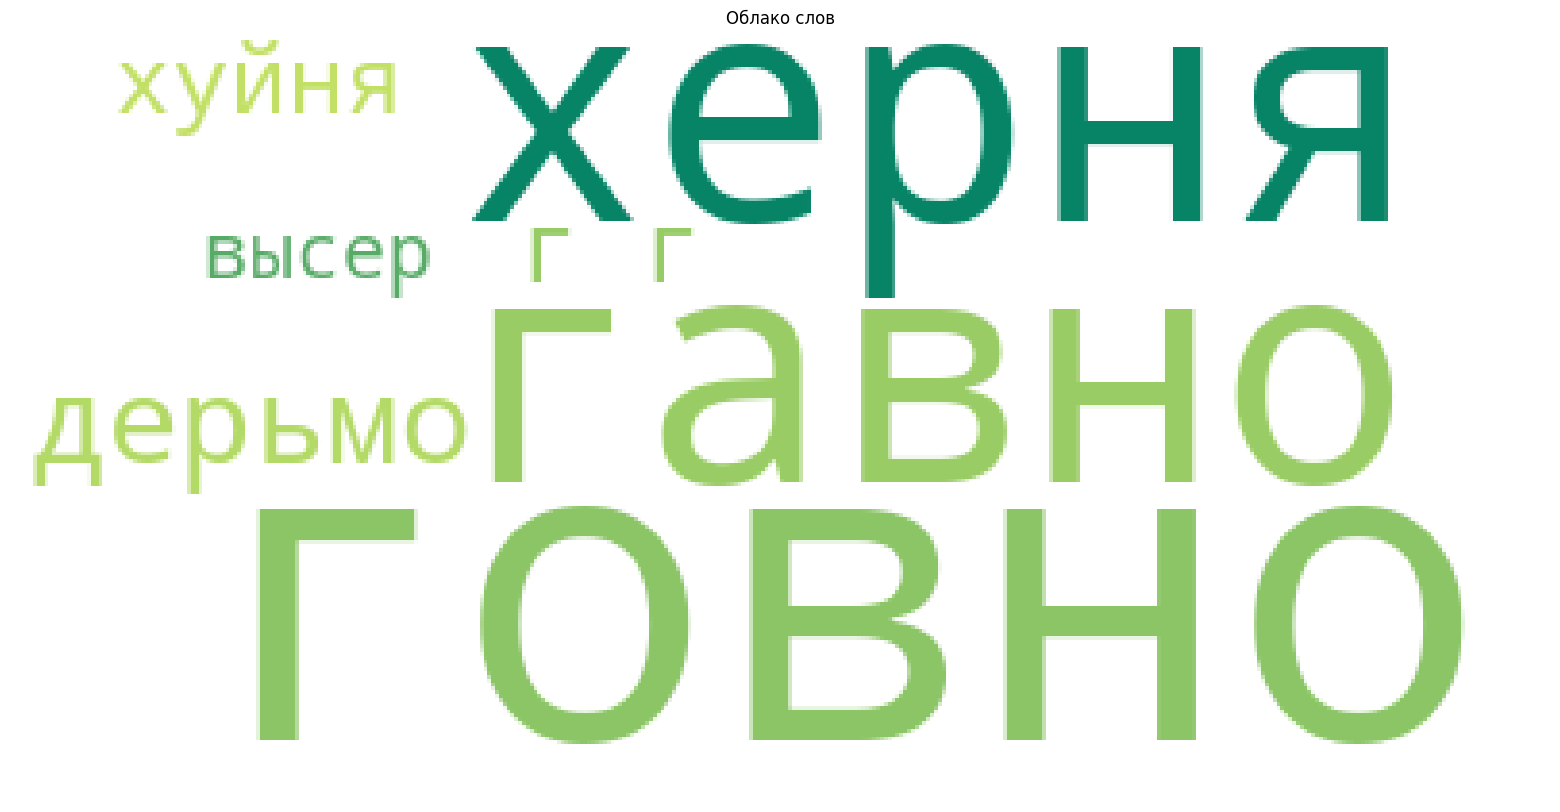

In [9]:
# облако слов

wc = WordCloud(background_color="white", max_words=200, margin=5,
               min_font_size=20, random_state=seed_val, colormap='summer')
wc.generate(data_train.label[(data_train.label.notnull())].to_string())
plt.figure(figsize=(20, 10))
plt.title("Облако слов")
plt.axis("off")
plt.imshow(wc)

In [10]:
def find_words_in_string(vocab: set, text: str, processing=None) -> list:
    """
    Данная функция находит находит слова из словаря в строке и возращает
    отсортированный список найденных слов.
    """
    # Преобразуем текст в нижний регистр и разбиваем его на слова
    prccessed_text = text.lower().translate(
        str.maketrans('', '', string.punctuation))
    words_in_text = prccessed_text.lower().strip().split()
    
    if processing == 'staming':
        words_in_text_proc = list(map(ss.stem, words_in_text))
    elif processing == 'limatization':
        words_in_text_proc = list(map(lambda x: morph.parse(x)[0].normal_form, words_in_text))
    else:
        words_in_text_proc = words_in_text

    positions = {}
    
    for index, word in enumerate(words_in_text_proc):
        if word in vocab:
            positions[word] = index

    return sorted([words_in_text[value] for value in positions.values()])

def find_patterns_in_words(patterns: set, text: str, processing=None) -> list:
    """
    Данная функция нужна для поиска слов в тексте, которые содержат определенные патерны.
    Возвращает отсортированный список найденных слов.
    """
    prccessed_text = text.lower().translate(
        str.maketrans('', '', string.punctuation)
    )
    words_in_text = prccessed_text.lower().strip().split()
    
    if processing == 'staming':
        words_in_text_proc = list(map(ss.stem, words_in_text))
    elif processing == 'limatization':
        words_in_text_proc = list(map(lambda x: morph.parse(x)[0].normal_form, words_in_text))
    else:
        words_in_text_proc = words_in_text

    positions = {}
    
    for index, word in enumerate(words_in_text_proc):
        for pattern in patterns:
            if pattern in word:
                positions[word] = index
                

    return sorted([words_in_text[value] for value in positions.values()])


In [11]:
# удаляем слова, которые ошибочно были занесены в словарь 

delete_words = ['полное', 'г', 'го', 'хрень', 'х'] + delete_words
delete_words_json = json.dumps(delete_words, ensure_ascii=False)
for word in delete_words:
    try:
        vocab.remove(word)
    except: continue

# delete_words = ['полное', 'полная', 'просто', 'простое', 
#                 'простой' 'г', 'го', 'хрень', 'х', 'на']
# delete_words_json = json.dumps(delete_words, ensure_ascii=False)
# for word in delete_words:
#     try:
#         vocab.remove(word)
#     except: continue

In [26]:
def test_review(vocab: set, find_mat: Callable, processing=None) -> dict:
    """
    Данная функция рассчитывает расстояние Левенштейна между таргет строкой и 
    предсказанной строкой, сформированной на основе словаря, и возвращает
    среднее расстояние Левенштейна и ошибки, получившиеся в результате 
    неверных предсказаний
    """
    mistakes = {}
    distance = 0
    distance_mat = 0
    
    for i, row in tqdm(data_test.iterrows(), unit_scale=True):
        found_words = ",".join(find_mat(vocab, row['text'], processing))
        label = row['label'] if row['label'] is not np.nan else ''
        current_distance = Levenshtein.distance(found_words, label)
        distance += current_distance

        if row['label'] is not np.nan:
            if i < 500:
                print("Найденные слова: ", found_words)
                print("Метка: ", row['label'])
                print()
            current_distance_mat =  Levenshtein.distance(found_words, label)
            distance_mat += current_distance_mat
        
        if current_distance > 0:
            if row['label'] not in mistakes.keys():
                mistakes[row['label']] = [found_words, current_distance]
            else:
                mistakes[row['label']] += [found_words, current_distance]

    mean_distance = distance / len(data_test)
    mean_distance_mat = distance_mat / len(data_test[~data_test['label'].isna()])
    
    return mistakes, mean_distance, mean_distance_mat

In [13]:
# # создание и логирование эксперимента

# task1 = Task.init(project_name='wb sprint2', task_name='vocab from dataset')
mistakes, mean_distance, mean_distance_mat = test_review(vocab, find_words_in_string)
print(f"Среднее расстояние Леветштейна: {mean_distance}")
print(f"Среднее расстояние Леветштейна для непустых label: {mean_distance_mat}")
# task1.connect({
#     'vocab': 'vocab from dataset all data',
#     'vocab_size': len(vocab),
#     'mean_distance': mean_distance,
#     'mean_distance_mat': mean_distance_mat,
#     'delete words': delete_words_json,
#     'processing': '-'
# })

# mistakes_path = '/kaggle/working/mistakes.pkl'
# with open(mistakes_path, 'wb') as f:
#     pickle.dump(mistakes, f)

# vocab_path = '/kaggle/working/vocab.json'
# with open(vocab_path, 'w', encoding='utf-8') as f:
#     json.dump(list(vocab), f, ensure_ascii=False)

# task1.upload_artifact('mistakes', artifact_object='/kaggle/working/mistakes.pkl')
# task1.upload_artifact('vocab', artifact_object=vocab_path)
# task1.close()

48.9kit [00:03, 14.7kit/s]

Среднее расстояние Леветштейна: 0.3089196698537223
Среднее расстояние Леветштейна для непустых label: 2.1596095880579878


In [ ]:
# # вывод самых частых ошибок 

# sorted_keys = sorted(mistakes, key=lambda k: len(mistakes[k]), reverse=True)

# # Выбираем первые 5 ключей
# top_5_keys = sorted_keys[:5]

# print("Ключи с самыми длинными значениями:", top_5_keys)
# print("Самые длинные значения:", [mistakes[key] for key in top_5_keys])

In [ ]:
# # тест модели

# previous_task_id = '7e9906757e204991ae08ca0ed3e142a1'  # Замените на ID вашего предыдущего эксперимента
# previous_task = Task.get_task(task_id=previous_task_id)

# vocab_artifact = previous_task.artifacts['vocab']
# vocab_path = vocab_artifact.get_local_copy()
# with open(vocab_path, 'rb') as f:
#     vocab = set(json.load(f))

# label = []
# for i, row in tqdm(test.iterrows(), unit_scale=True):
#     found_words = ",".join(find_words_in_string(vocab, row['text']))
#     label.append(found_words)

# answer = test.copy().drop('text', axis=1)
# answer['label'] = label
# answer.to_csv('answer.csv', index=False)

### Создание словаря с помощью BPE. На вход строка с уникальными матными словами

Предполагается, что с помощью токезатора BPE можно получить самые частые комбинации символов, находящихся рядом друг с другом. Таким образом, можно было бы выявить некие паттерны матных слов. В качестве строки для обучения токеназатора подадим 

In [15]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer


mat_uniq = " ".join(vocab_list)

with open("mat_uniq.txt", "w") as f:
    f.write(mat_uniq)

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]"], min_frequency=20, vocab_size=400)
tokenizer.train(["mat_uniq.txt"], trainer)
output = tokenizer.encode("пиздец нахуй бля асаламу")
print(output.tokens)




['пизд', 'ец', ' нахуй', ' бля', ' а', 'с', 'ал', 'а', 'м', 'у']


Необходимо удалить из токенезатора символы размером 1-2, так как они не похоже на паттерны мата

In [16]:
# Смотрим статистику по длине матных слов, чтобы убедиться, что мы не удалим
# много лишних паттернов

np_arr = pd.Series([len(i) for i in vocab_list])
print(np_arr.describe())
print("Количество матных слов длинной 2: ", len(np_arr[np_arr == 2]))

count    31950.000000
mean         5.677715
std          1.836952
min          0.000000
25%          5.000000
50%          5.000000
75%          6.000000
max         39.000000
dtype: float64
Количество матных слов длинной 2:  248


In [18]:
print("Длина исходного словаря токеназатора: ", len(tokenizer.get_vocab().items()))
min_token_length = 3
filtered = {token.strip(): idx for token, idx in tokenizer.get_vocab().items() if len(token.strip()) >= min_token_length}
filtered_vocab = set(filtered.keys())
print("Длина отфильтрованного словаря токеназатора: ", len(filtered_vocab))
print("Отфильтрованный словарь: ", filtered_vocab)

Длина исходного словаря токеназатора:  400
Длина отфильтрованного словаря токеназатора:  189
Отфильтрованный словарь:  {'ебан', 'сука', 'ись', 'херня дерьмо', 'ась', 'хер', 'ебал', 'задниц', 'жопе', 'педи', 'чмо', 'нахуй', 'рукожопы', 'дерьмо', 'ахуе', 'заебок', 'херня говно', 'суки', 'говно дерьмо', 'заебись', 'изд', 'херня гавно', 'хуй', 'блять', 'гомно', 'нти', 'говно высер', 'конч', 'говно еб', 'дерьмо гавно', 'говно на', 'гавно дерьмо', 'нтин', 'ахуен', 'пер', 'дер', 'хуе', 'херня херня', 'ные', 'хулиг', 'нихуя', 'х..', 'раз', 'хули', 'нище', 'дерьмо дерьмо', 'хера', 'пиздатые', 'пизда', 'гавно', 'пиздец', 'бля', 'сук', 'зад', 'обос', 'говно говн', 'наебал', 'хулиган', 'полное', 'заеба', 'пиздили', 'тая', 'хует', 'дермо', 'ахуй', 'пиздато', 'ебаная', 'пидо', 'пзд', 'тра', 'жопа', 'г.... г...', 'ень', 'бляха', 'мно', 'г....', 'залупа', 'г...но', 'збс', 'итель', 'пиздатая', 'говно хуйня', '...', 'жопы', 'вахуе', 'пздц', 'говнище', 'дерьмище', 'проебал', 'пизд', 'г....о', 'охуен', 'г

In [17]:
output = tokenizer.encode("довольный")
print(output.tokens)
# filtered_vocab = {'пизд', 'охуен', 'йня', 'заебись', 'говно'}

['до', 'в', 'ол', 'ь', 'ный']


In [27]:
# создание и логирование эксперимента find_patterns_in_words find_words_in_string

#task1 = Task.init(project_name='wb sprint2', task_name='vocab with BPE unique')
mistakes, mean_distance, mean_distance_mat = test_review(filtered_vocab, find_patterns_in_words)
print(f"Среднее расстояние Леветштейна: {mean_distance}")
print(f"Среднее расстояние Леветштейна для непустых label: {mean_distance_mat}")
# task1.connect({
#     'vocab': 'vocab from dataset all data',
#     'vocab_size': len(filtered_vocab),
#     'mean_distance': mean_distance,
#     'mean_distance_mat': mean_distance_mat,
#     'delete words': '',
#     'processing': '-',
#     'using tokenizer to split': 'False'
# })

# mistakes_path = '/kaggle/working/mistakes.pkl'
# with open(mistakes_path, 'wb') as f:
#     pickle.dump(mistakes, f)

# vocab_path = '/kaggle/working/vocab.json'
# with open(vocab_path, 'w', encoding='utf-8') as f:
#     json.dump(list(vocab), f, ensure_ascii=False)

# task1.upload_artifact('mistakes', artifact_object='/kaggle/working/mistakes.pkl')
# task1.upload_artifact('vocab', artifact_object=vocab_path)
# task1.close()

3.44kit [00:00, 4.25kit/s]

Найденные слова:  говно,держит,полное,пройдите,просто,трепать
Метка:  говно

Найденные слова:  говно,гораздо,деньги,использования,обычный,оказалась,очень,первого,промокла,размер,размеры,разочарован
Метка:  говно



11.0kit [00:02, 4.25kit/s]

Найденные слова:  отпиздили
Метка:  отпиздили



12.7kit [00:02, 4.33kit/s]

Найденные слова:  говно,день,полное
Метка:  говно



14.1kit [00:03, 4.32kit/s]

Найденные слова:  херабора
Метка:  херабора



18.0kit [00:04, 4.31kit/s]

Найденные слова:  браслета,день,ебаная,залупа,первый,хуй,хуйня
Метка:  залупа,ебаная,хуйня



28.2kit [00:06, 4.41kit/s]

Найденные слова:  водный,дохера,концнлярский,хрень,черный
Метка:  дохера



34.7kit [00:08, 4.08kit/s]

Найденные слова:  говно
Метка:  говно



43.3kit [00:10, 4.20kit/s]

Найденные слова:  говно,очень,полторы,продаете,серьезно
Метка:  говно,высер,говн



48.9kit [00:11, 4.29kit/s]

Среднее расстояние Леветштейна: 20.133141292800524
Среднее расстояние Леветштейна для непустых label: 22.14970575570547


Можно заметить, что данный метод имеет очень неплохой recall, но низкий precision. Это связано с тем, что объявленные патерны содержат элементы, которые встречаются и в обычных словах.

### Решение задачи детекции мата с помощью обучения модели Bert для задачи классификации токенов

In [18]:
import datasets 
from datasets import Dataset, DatasetDict
import numpy as np

from transformers import BertTokenizerFast 
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
import evaluate


import re
from razdel import tokenize

import logging
from transformers.trainer import logger as noisy_logger
import joblib


noisy_logger.setLevel(logging.WARNING)

def remove_emoji(text) -> str:
    """
    удаляет ээмоджи из строки
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

print(remove_emoji('👍!'))

!


In [62]:
# скачивание обученного токенайзера

model_checkpoint = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [20]:
# разбиение текста на токены и разметка токенов на классы

tags = []
tokens = []
for i, row in tqdm(data.iterrows(), unit_scale=True):
    prccessed_text = remove_emoji(row['text']).lower()
    raw_toks = tokenizer.tokenize(prccessed_text)
    words = []
    current_word = ""
    for token in raw_toks:
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
            current_word = token
    if current_word:
        words.append(current_word)
    tokens.append(words)
    mat = row['label']
    if mat is not np.nan:
        tags.append(['O' if word not in mat.split(',') else 'M' if word in vocab
                     else 'O' for word in words])
    else:
        tags.append(['O' for word in words])
    
data['tags'] = tags
data['tokens'] = tokens

4.06kit [00:01, 3.40kit/s]Token indices sequence length is longer than the specified maximum sequence length for this model (925 > 512). Running this sequence through the model will result in indexing errors
245kit [01:06, 3.70kit/s] 


In [38]:
data[~data['label'].isna()]

,ID,text,label,tags,tokens
32,32,говно а не товар,говно,"[M, O, O, O]","[говно, а, не, товар]"
36,36,"спасибо за уёбищние шарики!такой хуйни я еще не видела!спасибо за испорченое настроение!у вас больше никогда в жизни не куплю,и другим не советую,даже одной звезды вам мало","уёбищние,хуйни","[O, O, M, O, O, O, M, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[спасибо, за, уёбищние, шарики, !, такой, хуйни, я, еще, не, видела, !, спасибо, за, испорченое, настроение, !, у, вас, больше, никогда, в, жизни, не, куплю, ,, и, другим, не, советую, ,, даже, одной, звезды, вам, мало]"
39,39,пришла какая-то х....та вы там чё курите?,х...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[пришла, какая, -, то, х, ., ., ., ., та, вы, там, чё, курите, ?]"
53,53,"полное говно, не липнет пустая трата денег",говно,"[O, M, O, O, O, O, O, O]","[полное, говно, ,, не, липнет, пустая, трата, денег]"
58,58,"на вид очень даже ничего. но хочу сказать, что по качеству полное г... прислали еще и грязную. заявленную цену оно не стоит. 🤔",г...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[на, вид, очень, даже, ничего, ., но, хочу, сказать, ,, что, по, качеству, полное, г, ., ., ., прислали, еще, и, грязную, ., заявленную, цену, оно, не, стоит, .]"
...,...,...,...,...,...
244734,248088,мне ее порвали суки,суки,"[O, O, O, M]","[мне, ее, порвали, суки]"
244735,248089,"Полное дерьмо, удалите этот товар и заблокируйте продавца",дерьмо,"[O, M, O, O, O, O, O, O, O]","[полное, дерьмо, ,, удалите, этот, товар, и, заблокируйте, продавца]"
244736,248090,Херня. Деньги на ветер.,херня,"[M, O, O, O, O, O]","[херня, ., деньги, на, ветер, .]"
244737,248091,"Это вообще что , за 💩 гов... ще?? Темнотища ужас!! Тонкая промашка 👎, рвётся, морщица и не расправляется, рисунок в некоторых местах не совпадает.. Еле от стены отшкрябала, в полном смысле. Стена новый гипсокартон, весь в краске покрасился🤦не рекомендую 👎👎👎👎 от слова СОВСЕМ!!!!",гов... ще,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[это, вообще, что, ,, за, гов, ., ., ., ще, ?, ?, темнотища, ужас, !, !, тонкая, промашка, ,, рвётся, ,, морщица, и, не, расправляется, ,, рисунок, в, некоторых, местах, не, совпадает, ., ., еле, от, стены, отшкрябала, ,, в, полном, смысле, ., стена, новый, гипсокартон, ,, весь, в, краске, покрасилсяне, рекомендую, от, слова, совсем, !, !, !, !]"


In [21]:
# разбиение данные на треин и тест. Создание объектов Dataset

data_train, data_test = train_test_split(data.drop(['ID', 'text'], axis=1), test_size=0.2)
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

ner_data = DatasetDict({
    'train': Dataset.from_pandas(data_train),
    'test': Dataset.from_pandas(data_test)
})
ner_data

DatasetDict({
    train: Dataset({
        features: ['label', 'tags', 'tokens'],
        num_rows: 195791
    })
    test: Dataset({
        features: ['label', 'tags', 'tokens'],
        num_rows: 48948
    })
})

In [22]:
label_list = ['O', 'M']
def tokenize_and_align_labels(example: pd.DataFrame, label_all_tokens=True):
    """
    Данная функция предназначена, чтобы создать столбцы 
    ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    предназначенные для обучения модели Bert
    """
    tokenized_inputs = tokenizer(example['tokens'], truncation=True, is_split_into_words=True)
    label = example['tags']
    
    if len(label) == 0:
        tokenized_inputs['labels'] = []
        return tokenized_inputs
        
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    
    for word_idx in word_ids:
        # Special tokens have a word id that is None. We set the label to -100 so they are automatically
        # ignored in the loss function.
        if word_idx is None:
            label_ids.append(-100)
        # We set the label for the first token of each word.
        elif word_idx != previous_word_idx:
            #print(word_idx, 'word_idx')
            label_ids.append(label[word_idx])
        # For the other tokens in a word, we set the label to either the current label or -100, depending on
        # the label_all_tokens flag.
        else:
            #print(word_idx, 'previous')
            label_ids.append(label[word_idx] if label_all_tokens else -100)
        previous_word_idx = word_idx

    label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]
    tokenized_inputs["labels"] = label_ids
    
    return tokenized_inputs


In [23]:
# добавление необходимых столбцов и удаление ненужных для работы Bert

tokenized_datasets = ner_data.map(tokenize_and_align_labels)
tokenized_datasets = tokenized_datasets.remove_columns(['tags', 'tokens', 'label'])
tokenized_datasets

Map:   0%|          | 0/195791 [00:00<?, ? examples/s]

Map:   0%|          | 0/48948 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 195791
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 48948
    })
})

In [42]:
tokenized_datasets['train'][0]['attention_mask']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [27]:
# загрузка предобученной модели

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model.config.id2label = dict(enumerate(label_list))
model.config.label2id = {v: k for k, v in model.config.id2label.items()}


model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
def compute_metrics(p, **kwargs):
    """
    Данная функция предназначена для подсчета метрик на тестовой выборке при
    обучении модели. Так же результы логируются в clearml
    """
    predictions, labels = p.predictions, p.label_ids
    input_ids = p.inputs
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(len(true_predictions)):
        for j in range(len(true_predictions[i])):
            if true_predictions[i][j] == true_labels[i][j] == 'M':
                tp += 1
            if true_predictions[i][j] == true_labels[i][j] == 'O':
                tn += 1
            if true_predictions[i][j] == 'O' and true_labels[i][j] == 'M':
                fn += 1
            if true_predictions[i][j] == 'M' and true_labels[i][j] == 'O':
                fp += 1
                
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    try:
        recall = tp / (tp + fn)
    except:
        recall = 0
    try:
        precision = tp / (tp + fp)
    except:
        precision = 0
    try:
        f1 = 2 * recall * precision / (recall + precision)
    except: f1 = 0
        
    task.get_logger().report_scalar(title='Metrics', series='accuracy', value=accuracy, iteration=trainer.state.global_step)
    task.get_logger().report_scalar(title='Metrics', series='precision', value=precision, iteration=trainer.state.global_step)
    task.get_logger().report_scalar(title='Metrics', series='recall', value=recall, iteration=trainer.state.global_step)
    task.get_logger().report_scalar(title='Metrics', series='f1', value=f1, iteration=trainer.state.global_step)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [25]:
# создание эксперермента в clearml
task = Task.init(project_name='wb sprint2', task_name='rubert-tiny any M label in tokens 2 TEST2')

ClearML Task: created new task id=3de5509697c54b6f9926fc7713afc5f1
2025-01-18 14:56:08,062 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2025-01-18 14:56:08,068 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/ac60ac97556c43978ea64418f728663a/experiments/3de5509697c54b6f9926fc7713afc5f1/output/log
2025-01-18 14:56:08,598 - clearml.log - WARNING - Event reporting sub-process lost, switching to thread based reporting


/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:633: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ClearML results page: https://app.clear.ml/projects/ac60ac97556c43978ea64418f728663a/experiments/3de5509697c54b6f9926fc7713afc5f1/output/log
2025-01-18 15:48:57,494 - clearml.storage - INFO - Uploading: 44.62MB to /kaggle/working/model_rubert.pth


/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:633: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

██████████████████████████████▉ 100% | 44.62/44.62 MB [00:00<00:00, 72.53MB/s]: 


In [29]:
# Обучение модели Bert

for param in model.parameters():
    param.requires_grad = True


batch_size = 32
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
args = TrainingArguments(
    "ner",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=8,
    weight_decay=0.01,
    save_strategy='no',
    logging_steps=10,
    report_to=["clearml"]
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



2025-01-18 14:57:01,269 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.006400,0.006726,0.917207,0.904859,0.910991,0.998031
2,0.004500,0.005360,0.907115,0.951242,0.928654,0.998372
3,0.002000,0.004459,0.922628,0.957124,0.939560,0.998629
4,0.004700,0.004324,0.918023,0.966627,0.941698,0.998667
5,0.001100,0.003974,0.927457,0.964704,0.945714,0.998767
6,0.005400,0.003862,0.933359,0.964138,0.948499,0.998834
7,0.003200,0.003869,0.929844,0.968607,0.948829,0.998837
8,0.002500,0.003843,0.931863,0.967758,0.949471,0.998853


TrainOutput(global_step=48952, training_loss=0.005786239095421114, metrics={'train_runtime': 2481.6937, 'train_samples_per_second': 631.153, 'train_steps_per_second': 19.725, 'total_flos': 3759313013509428.0, 'train_loss': 0.005786239095421114, 'epoch': 8.0})

In [ ]:
# загрузка модели из предыдущих эксперементов

# previous_task_id = '104bc56cbbf048bf8368bf9f60fe732f'  # Замените на ID вашего предыдущего эксперимента
# previous_task = Task.get_task(task_id=previous_task_id)
# model_artifact = previous_task.artifacts['model']
# model_path = model_artifact.get_local_copy()

# model = joblib.load(model_path)

In [28]:
print(model_path) 

/root/.clearml/cache/storage_manager/global/8ce16e0fef1c1dcd1990ac224bdb1744.topic_saved_weights.pth


In [30]:
# подсчет расстояния Ливенштейна для обученной модели

distance = 0
distance_mat = 0
k = 0
count_mat = 0

for i, row in tqdm(data_test.iterrows(), unit_scale=True):
    try:
        label = row['label'] if row['label'] is not np.nan else ''
        text = ' '.join(row['tokens'])
        tokens = tokenizer(text, return_tensors='pt')
        tokens = {k: v.to(model.device) for k, v in tokens.items()}
        with torch.no_grad():
            pred = model(**tokens)
            
        words = []
        labels = []
        current_word = []
        current_label = None
        indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
        token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
        
        for t, idx in zip(token_text, indices):
            if t.startswith("##"):
                current_word.append(t[2:])
                if idx == 'M':
                    curent_label = idx
            else:
                if current_word:
                    words.append("".join(current_word))
                    labels.append(current_label)
                current_word = [t]
                current_label = idx
        
        # Добавление последнего слова и метки
        if current_word:
            words.append("".join(current_word))
            labels.append(current_label)
            
        mats = []
        
        for word, label in zip(words, labels):
            if label_list[label] == 'M':
                mats.append(word)
                
        sorted(mats)
        predict = ",".join(mats)
        label = row['label'] if row['label'] is not np.nan else ''
        current_distance = Levenshtein.distance(predict, label)
        distance += current_distance
    
        if row['label'] is not np.nan:
            current_distance_mat = Levenshtein.distance(predict, label)
            distance_mat += current_distance_mat
            count_mat += 1
            
    except:
        k += 1
        continue

mean_distance = distance / (len(data_test) - k)
mean_distance_mat = distance_mat / count_mat

print(f"Среднее расстояние Леветштейна: {mean_distance}")
print(f"Среднее расстояние Леветштейна для непустых label: {mean_distance_mat}")

48.9kit [02:46, 294it/s]

Среднее расстояние Леветштейна: 0.3943518064410659
Среднее расстояние Леветштейна для непустых label: 2.649002849002849


При обучении модели мы видим, что recall выше precision. При этом наш метод с BPE имеет тоже хороший отклик. А что, если сделать ансамбль из двух моделей, где первая будет выдавать свою метку на основе BERT, а вторая будет смотреть, содержит слово патерн из BPE

In [54]:
# подсчет расстояния Ливенштейна для обученной модели используя ансамбль модели

distance = 0
distance_mat = 0
k = 0
count_mat = 0

for i, row in tqdm(data_test.iterrows(), unit_scale=True):
    try:
        label = row['label'] if row['label'] is not np.nan else ''
        text = ' '.join(row['tokens'])
        tokens = tokenizer(text, return_tensors='pt')
        tokens = {k: v.to(model.device) for k, v in tokens.items()}
        with torch.no_grad():
            pred = model(**tokens)
            
        words = []
        labels = []
        current_word = []
        current_label = None
        indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
        token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
        
        for t, idx in zip(token_text, indices):
            if t.startswith("##"):
                current_word.append(t[2:])
                if idx == 'M':
                    curent_label = idx
            else:
                if current_word:
                    words.append("".join(current_word))
                    labels.append(current_label)
                current_word = [t]
                current_label = idx
        
        # Добавление последнего слова и метки
        if current_word:
            words.append("".join(current_word))
            labels.append(current_label)
            
        mats = []
        
        for word, label in zip(words, labels):
            if label_list[label] == 'M':
                 for pattern in filtred_vocab:
                    if pattern in word:
                        mats.append(word)
                        break
                
        sorted(mats)
        predict = ",".join(mats)
        label = row['label'] if row['label'] is not np.nan else ''
        current_distance = Levenshtein.distance(predict, label)
        distance += current_distance
    
        if row['label'] is not np.nan:
            current_distance_mat = Levenshtein.distance(predict, label)
            distance_mat += current_distance_mat
            count_mat += 1
            
    except:
        k += 1
        continue

mean_distance = distance / (len(data_test) - k)
mean_distance_mat = distance_mat / count_mat

print(f"Среднее расстояние Леветштейна: {mean_distance}")
print(f"Среднее расстояние Леветштейна для непустых label: {mean_distance_mat}")

48.9kit [02:45, 295it/s]

Среднее расстояние Леветштейна: 0.19320717872419566
Среднее расстояние Леветштейна для непустых label: 6.897095435684648


In [36]:
# task.connect({
#     'mean_distance': mean_distance,
#     'mean_distance_mat': mean_distance_mat,
# })
# model_path = '/kaggle/working/model_rubert.pth'
# joblib.dump(model, 'model_rubert.pth', protocol=4)
# Загрузка модели в ClearML
task.upload_artifact(name='model_rubert1', artifact_object="model_rubert.pth")
task.close()

KeyboardInterrupt: 

In [ ]:
# tokens = []
# for i, row in tqdm(test.iterrows(), unit_scale=True):
#     prccessed_text = remove_emoji(row['text']).lower()
#     raw_toks = tokenizer.tokenize(prccessed_text)
#     words = []
#     current_word = ""
#     for token in raw_toks:
#         if token.startswith("##"):
#             current_word += token[2:]
#         else:
#             if current_word:
#                 words.append(current_word)
#             current_word = token
#     if current_word:
#         words.append(current_word)
#     tokens.append(words)
    

# test['tokens'] = tokens

In [41]:
filtered_vocab

{'...',
 '[UNK]',
 'ано',
 'ась',
 'ать',
 'аху',
 'ахуе',
 'ахуен',
 'ахуенная',
 'ахуенно',
 'ахуенны',
 'ахуенные',
 'ахуенный',
 'ахуй',
 'бля',
 'блять',
 'блях',
 'бляха',
 'вать',
 'вахуе',
 'вно',
 'вый',
 'высер',
 'г..',
 'г...',
 'г....',
 'г.... г...',
 'г.....',
 'г..... г.... г...',
 'г....о',
 'г...но',
 'г...о',
 'г...о г...',
 'гав',
 'гавно',
 'гавно гавно',
 'гавно говно',
 'гавно дерьмо',
 'гавно херня',
 'гамно',
 'гов',
 'говн',
 'говна',
 'говнище',
 'говно',
 'говно бл',
 'говно бля',
 'говно высер',
 'говно гавно',
 'говно говн',
 'говно говно',
 'говно дерьмо',
 'говно еб',
 'говно жоп',
 'говно на',
 'говно о',
 'говно рукожоп',
 'говно херня',
 'говно хуйня',
 'говном',
 'гомно',
 'дер',
 'дермо',
 'дерь',
 'дерьм',
 'дерьма',
 'дерьмище',
 'дерьмо',
 'дерьмо гавно',
 'дерьмо говно',
 'дерьмо дерьмо',
 'дерьмо херня',
 'долб',
 'еба',
 'ебал',
 'ебан',
 'ебаная',
 'ебу',
 'ель',
 'ень',
 'жоп',
 'жопа',
 'жопе',
 'жопу',
 'жопы',
 'зад',
 'задниц',
 'задница

In [72]:
# предсказание на тестовых данных 

predictions = []

for i, row in tqdm(test.iterrows(), unit_scale=True):
    try:
        label = row['label'] if row['label'] is not np.nan else ''
        text = row['text']
        tokens = tokenizer(text, return_tensors='pt')
        tokens = {k: v.to(model.device) for k, v in tokens.items()}
        with torch.no_grad():
            pred = model(**tokens)
        words = []
        labels = []
        current_word = []
        current_label = None
        indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
        token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
        for t, idx in zip(token_text, indices):
            if t.startswith("##"):
                current_word.append(t[2:])
                if idx == 'M':
                    curent_label = idx
            else:
                if current_word:
                    words.append("".join(current_word))
                    labels.append(current_label)
                current_word = [t]
                current_label = idx
        
        # Добавление последнего слова и метки
        if current_word:
            words.append("".join(current_word))
            labels.append(current_label)
        mats = []
        for word, label in zip(words, labels):
            if label_list[label] == 'M':
                for pattern in filtered_vocab:
                    if pattern in word:
                        mats.append(word)
                        break
        sorted(mats)
        predict = ",".join(mats)
        if predict == '':
             predictions.append(np.nan)
        else:
            predictions.append(predict)
    except:
        predictions.append(np.nan)
        continue

test['label'] = predictions

66.9kit [03:46, 295it/s]


In [73]:
test

,ID,text,label
0,0,"хороший, подошкл",NaN
1,1,"совсем тонюсенький саженец, не досмотрела в описании, что он годовалый:(",NaN
2,2,"когтеточка хорошая, но вот ткань на основании плохо приклеяна, пришлось доделывать чтоб мех не столз. кошаки осваивают.",NaN
3,3,"много затяжек, не порадовала покупка",NaN
4,4,рекомендую 💣,NaN
...,...,...,...
66944,71995,"Пачка как пачка а внутри совсем другое \nНекторве мелкие , почти как напалечник \nВ пачке из трех один более мение \nВообщем говно",говно
66945,71996,"Отвратительное качество!!! Через год тряпка, у супруга есть разных производителей нижнее белье, которое и по 3-5лет в приличном состоянии остаётся), но это просто швах!!!!! Продавец, имейте совесть, за такие деньги такое г… о!! Ну прям не честно!!!",NaN
66946,71997,"Вес 100гр, не понимаю откуда хорошие отзывы , полное г...",NaN
66947,71998,"Приобрел и установил радиатор год назад , автомобиль практически не выезжал , летом заметил подтёки подумал что патрубок капает , но оказалось течет сам радиатор , до этого стоял такой же отработал лет 8 без проблем \nКачество стало полное говно к покупке не рекомендую лучше взять что-то лучше в идеале медный , но там ценник конский \nПроизводителю хочется пожелать здоровья и таких же качественных запчастей на его автомобиль",говно


In [74]:
test[['ID', 'label']].to_csv('answer12-ansambl.csv', index=False)

In [ ]:
test